# Proof of concept - online rhat

This proof of concept computes split rhat for multichain inference, for a single posterior using GHMC/Blackjax with MEADS warmup.

The model is a simple Gaussian linear regression. Rhat calcs are validated against Arviz.

In [86]:
import blackjax
import jax
import chex
import jax.numpy as jnp
import arviz as az
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
import matplotlib.pyplot as plt
from typing import NamedTuple
from jax.tree_util import tree_map, tree_structure, tree_flatten, tree_unflatten
import pandas as pd

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

ADT for the welford algorithm that tracks mean, absolute mean deviation, and variance for each chain variable of interest. This type will end up being the leaf of a pytree structured like the parameter.

In [87]:
class WelfordState(NamedTuple):
    K: chex.Array  # central estimate of data
    Ex: chex.Array  # sum of deviations from K
    Eax: chex.Array  # sum of absolute deviations from K
    Ex2: chex.Array  # sum of squared deviations from K
    n: chex.Array  # number of data points


def welford_init(K: chex.Array) -> WelfordState:
  """Initialize new welford algorithm state.
  
  Args:
    K: estimated mean value of data. Same shape as data.
  """
  return WelfordState(K=K*1., Ex=K*0., Eax=K*0., Ex2=K*0., n=K*0)

def welford_add(x: chex.Array, state: WelfordState) -> WelfordState:
  return WelfordState(
    K=state.K,
    Ex=state.Ex + x - state.K,
    Eax=state.Eax + jnp.abs(x - state.K),
    Ex2=state.Ex2 + (x - state.K)**2,
    n=state.n + 1)

def welford_mean(state: WelfordState):
  return state.K + state.Ex / state.n

def welford_mad(state: WelfordState):
  return state.Eax / state.n

def welford_var(state: WelfordState):
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)

In [88]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [89]:
def split_rhat(means: chex.Array, vars: chex.Array, n: int) -> float:
    """Compute a single split Rhat from summary statistics of split chains.

    Args:
        means: means of split chains
        vars:  variances of split chains
        n:     number of draws per split chain (ie half draws in an original chain)
    """
    W = jnp.mean(vars, axis=0)
    m = len(means)  # number of split chains
    B = n*jnp.var(means, ddof=1, axis=0)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat

def split_rhat_welford(ws: WelfordState) -> float:
    """Compute split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    
    Returns:
        split Rhat: array of split Rhats
    """
    means = jax.vmap(welford_mean)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[0]
    return split_rhat(means, vars, n)

def folded_split_rhat_welford(ws: WelfordState) -> float:
    """Compute folded split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    
    Returns:
        folded split Rhat: array of folded split Rhats
    """
    mads = jax.vmap(welford_mad)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[0]
    return split_rhat(mads, vars, n)

def rhat(welford_tree):
    """Compute split Rhat and folded split Rhat from welford states of split chains.
    
    Args:
        welford_tree: pytree of Welford states for split chains
    
    Returns:
        split Rhat: pytree pytree of split Rhats
        folded split Rhat: pytree of folded split Rhats
    """
    # first two axes are (chain #, half #), which we combine to a single dimension
    com_chains = tree_map(lambda x: jnp.reshape(x, (-1, *x.shape[2:])), welford_tree)
    sr = tree_map(split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    fsr = tree_map(folded_split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    return sr, fsr

In [90]:
class ExtendedState(NamedTuple):
    state: blackjax.mcmc.hmc.HMCState  # current HMC state
    rng_key: chex.Array  # current random seed
    pred_ws: WelfordState  # accumulator for predictive
    param_ws: WelfordState  # accumulator for parameters
    divergences: chex.Array  # divergence counts (int array)

    def diagnostics(self) -> None:
        """Summarize the state of this object."""
        # TODO: add mean and s.e. of the parameters
        rhats = [(n, rhat(v)) for n, v in zip(self.param_ws._fields, self.param_ws)]
        predrh, predsrh = rhat(self.pred_ws)
        status = [
            f'       Summary: {int(jnp.sum(self.pred_ws.n[0,:]))} draws * {self.state.position[0].shape[0]} chains',
        ]
        param = [f'{n: >9} Rhat: {v} ({desc})' for n, (rh, frh) in rhats for v, desc in [(rh, 'regular'), (frh, 'tail')]]
        lines = status + param + [
            f"    pred. Rhat: {predrh:.4f}  tail: {predsrh:.4f}",
            f"   divergences: {int(jnp.sum(self.divergences))}"
        ]
        print('\n'.join(lines))


## Model definition

In [91]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)
# y = y.at[23].set(400.0)  # outlier

In [92]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

def logprob_fn(theta: Theta):
  sigsq = sigsq_t.forward(theta.sigsq)
  sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
  lprior = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(theta.sigsq)
  lhood = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y).sum()
  return lprior + lhood

# predictive density log p(y|theta)
def log_p(theta):
    e = X @ theta.beta - y
    return -0.5 * (
        jnp.log(2 * jnp.pi)
        + jnp.log(theta.sigsq)
        + jnp.dot(e, e)/theta.sigsq
    )


In [93]:
num_samples = 1000
warmup_iter = 500
num_chains = 10
seed = 123
warmup_key, sampling_key, init_key, subs_key = jax.random.split(jax.random.PRNGKey(seed), 4)

# random initialization in the constrained parameter space
def make_initial_pos(key):
  k1, k2 = jax.random.split(key)
  theta = Theta(
    beta=jax.random.normal(key=k1, shape=(p,)),
    sigsq=jax.random.normal(key=k2))
  return theta

## Inference

In [94]:
%%time

meads = blackjax.meads(logprob_fn, num_chains)
init_chain_keys = jax.random.split(init_key, num_chains)
init_states = jax.vmap(make_initial_pos)(init_chain_keys)
final_warmup_state, kernel, info = meads.run(warmup_key, init_states)

CPU times: user 3.17 s, sys: 202 µs, total: 3.17 s
Wall time: 3.15 s


In [95]:
# stack arrays in pytrees
def tree_stack(trees):
    return tree_map(lambda *xs: jnp.stack(xs, axis=0), *trees)

# stack arrays in pytrees
def tree_concat(trees):
    return tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *trees)

In [96]:
# sample initial positions from second half of warmup trajectory
idxs = jax.random.choice(subs_key, a=jnp.arange(warmup_iter//2, warmup_iter), shape=(num_chains,))
initial_positions = Theta(
    beta = info[0].position.beta[idxs,],
    sigsq = info[0].position.sigsq[idxs]
)
centers = tree_map(lambda x: jnp.median(x[-10:,...], axis=(0, 1)), info[0].position)
# I'm sure there's a jax-y way to do this, but this is the simplest thing that works
#initial_states = [tree_map(lambda x: x[i,...] if jnp.ndim(x) > 0 else x, final_warmup_state.states) for i in range(num_chains)]

In [97]:
# sense check logprob_fn
lps = jax.vmap(logprob_fn)(final_warmup_state.states.position)
assert jnp.all(jnp.isfinite(lps)) and jnp.all(lps < 0)
print(f'Initial log p(theta) = {lps}')

Initial log p(theta) = [-194.3719  -192.06485 -190.96971 -192.58066 -191.98457 -190.36009
 -191.26689 -191.4387  -193.48213 -191.01991]


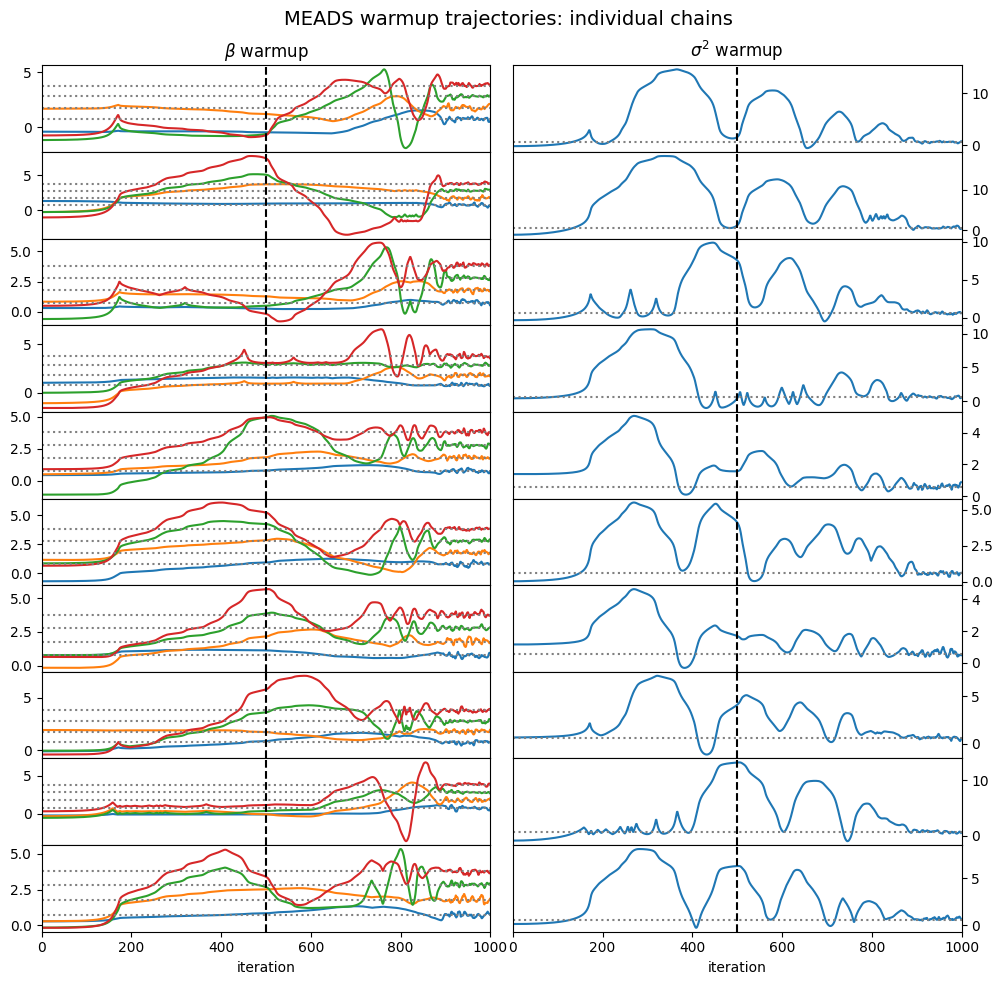

In [98]:
fig, axes = plt.subplots(nrows=num_chains, ncols=2, figsize=(10, max(2.5, num_chains)))
meads_iter = info[0].position[i].shape[0]
for j in range(num_chains):
    for i, (ax, n) in enumerate(zip(axes[j,:], ['beta', 'sigma^2'])):
        if j == 0:
            ax.set_title(f'$\\{n}$ warmup')
        if j == num_chains - 1:
            ax.set_xlabel('iteration')
        else:
            ax.set_xticks([])
        if i == 1:
            ax.yaxis.tick_right()
        draws = info[0].position[i]
        chain_draws = draws[:,j,...]
        ax.plot(chain_draws)
        ax.axvline(meads_iter//2, color='k', linestyle='--')
        ax.set_xlim(0, meads_iter)
        if centers[i].ndim > 0:
            for c in centers[i]:
                ax.axhline(c, color='gray', linestyle=':')
        else:
            ax.axhline(centers[i], color='gray', linestyle=':')
fig.suptitle('MEADS warmup trajectories: individual chains', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.05)


Named tuple for holding MCMC results, split into 2 half-chains

In [99]:
# single chain inference loop we will run in parallel using vmap
def inference_loop(rng_key, kernel, initial_state, num_samples, log_p, centers):
    def one_mcmc_step(ext_state, idx):
        i_key, carry_key = jax.random.split(ext_state.rng_key)
        chain_state, chain_info = kernel(i_key, ext_state.state)
        elpd_contrib = log_p(chain_state.position)
        div_count = ext_state.divergences + chain_info.is_divergent.astype(jnp.float32)
        carry_pred_ws = welford_add(elpd_contrib, ext_state.pred_ws)
        carry_param_ws = tree_map(welford_add, chain_state.position, ext_state.param_ws)
        carry_state = ExtendedState(chain_state, carry_key, carry_pred_ws, carry_param_ws, div_count)
        return carry_state, chain_state  # we'll eventually drop chain state and return None instead
    # first half of chain
    initial_state_1h = ExtendedState(
        initial_state,
        rng_key,
        pred_ws=welford_init(log_p(centers)),
        param_ws=tree_map(welford_init, centers),
        divergences=0)
    #carry_state_1h = jax.lax.fori_loop(0, num_samples//2, one_step, initial_state_1h)
    carry_state_1h, states_1h = jax.lax.scan(one_mcmc_step, initial_state_1h, jnp.arange(0, num_samples//2))
    # second half of chain - continue at same point but accumulate into new welford states
    initial_state_2h = ExtendedState(
        carry_state_1h.state,
        carry_state_1h.rng_key,
        pred_ws=welford_init(log_p(centers)),
        param_ws=tree_map(welford_init, centers),
        divergences=0)
    #carry_state_2h = jax.lax.fori_loop(0, num_samples//2, one_step, carry_state_1h)
    carry_state_2h, states_2h = jax.lax.scan(one_mcmc_step, initial_state_2h, jnp.arange(num_samples//2, num_samples))
    return tree_stack((carry_state_1h, carry_state_2h,)), tree_concat((states_1h, states_2h,))

In [100]:
def to_arviz(theta):
    theta_dict = dict(zip(theta.position._fields, theta.position))
    return az.convert_to_inference_data(theta_dict)

In [101]:
sampling_keys = jax.random.split(sampling_key, num_chains)

#state, trace = inference_loop(sampling_keys[0], kernel, initial_states[0], num_samples, log_p, centers)

In [102]:
%%time

state, trace = jax.vmap(inference_loop, in_axes=(0, None, 0, None, None, None))(sampling_keys, kernel, final_warmup_state.states, num_samples, log_p, centers)

CPU times: user 2.6 s, sys: 15.6 ms, total: 2.62 s
Wall time: 2.6 s


In [103]:
state.diagnostics()

       Summary: 1000 draws * 10 chains
     beta Rhat: [1.005904  1.002332  1.0095186 1.009604 ] (regular)
     beta Rhat: [1.0008061 1.0005168 1.0027088 1.000641 ] (tail)
    sigsq Rhat: 1.004482388496399 (regular)
    sigsq Rhat: 1.0007998943328857 (tail)
    pred. Rhat: 1.0037  tail: 1.0006
   divergences: 0


## Results

In [104]:
trace_az = to_arviz(trace)
az.summary(trace_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.761,0.146,0.486,1.035,0.003,0.002,2165.0,3174.0,1.01
beta[1],1.785,0.140,1.519,2.045,0.003,0.002,2402.0,3439.0,1.00
beta[2],2.789,0.128,2.540,3.020,0.004,0.003,1185.0,2013.0,1.01
beta[3],3.797,0.140,3.535,4.057,0.004,0.003,1521.0,1996.0,1.01
sigsq,0.647,0.149,0.374,0.935,0.003,0.002,2429.0,3598.0,1.00


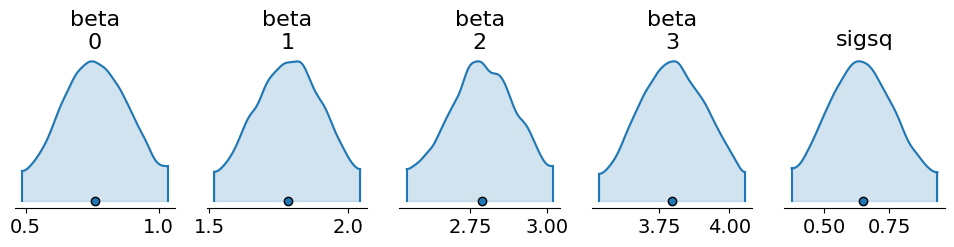

In [105]:
az.plot_density(trace_az, var_names=['beta', 'sigsq'], figsize=(12,2), shade=0.2, grid=(1,5));

Compute split Rhat for the parameter

In [106]:
s_rhats, fs_rhats = rhat(state.param_ws)
print("Regular split rhats")
print(s_rhats)
print("Folded split rhats")
print(fs_rhats)

Regular split rhats
Theta(beta=Array([1.005904 , 1.002332 , 1.0095186, 1.009604 ], dtype=float32), sigsq=Array(1.0044824, dtype=float32))
Folded split rhats
Theta(beta=Array([1.0008061, 1.0005168, 1.0027088, 1.000641 ], dtype=float32), sigsq=Array(1.0007999, dtype=float32))


And compare it with Arviz

In [107]:
rhats_df_az = az.rhat(trace_az, method='split').to_dataframe()
# verify they match
assert jnp.linalg.norm(rhats_df_az.beta.to_numpy() - s_rhats.beta) < 1e-6
assert jnp.abs(rhats_df_az.sigsq.to_numpy()[0] - s_rhats.sigsq) < 1e-6
print("Our split Rhats match Arviz")
rhats_df_az

Our split Rhats match Arviz


,beta,sigsq
beta_dim_0,,
0,1.005904,1.004482
1,1.002332,1.004482
2,1.009519,1.004482
3,1.009604,1.004482


Now compute Rhat for predictive quantity (in this case log density)

In [108]:
prh, pfrh = rhat(state.pred_ws)
print(f'Predictive regular rhat = {prh}, predictive folded rhat = {pfrh}')

Predictive regular rhat = 1.003716230392456, predictive folded rhat = 1.000558614730835
